# Задача сегментации. Библиотека segmentation_models_pytorch

## Transposed convolution. Задача сегментации
Статья: [Vincent Dumoulin "A guide to convolution arithmetic for deep
learning"](https://arxiv.org/pdf/1603.07285.pdf)

Все предыдущие сверточные нейронные сети в конце были снабжены полносвязными слоями, следовательно их вывод НЕ мог быть матрицей, то есть его нельзя интерпретировать как изображение. Однако для некоторых задач необходимо использовать нейросети, которые на вход получают изображения и на вывод также подают изображения (причем той же размерности).

Один из подходов, который можно реализовать - это использовать ТОЛЬКО сверточные слои и same padding для сохранения размерности. Такие нейронные сети обозначают как fcn (fully convolutional networks). Однако у такого подхода существует проблема: помимо слоев свертки есть слои пулинга, которые понижают размерность изображения, но при этом позволяют извлекать информацию.

Позже, в качестве альтернативы fcn была предложена архитектура Encoder-Decoder: encoder понижал размерность изображения  с помощью сверток и пулинга, а decoder повышал размерность. Ниже представлена архитектура UNet, одна из самых мощных нейросетей для задачи сегментации:

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*f7YOaE4TWubwaFF7Z1fzNw.png">


Как видно из описания блоков, за повышение размерности отвечает блок up_conv (он же transposed convolution, он же deconvolution). Как он устроен, мы сейчас разберемся.

Изображение делится на маленькие фрагментики, которые снабжаются паддингом, а потом сворачиваются с фильтром, в итоге размер фрагмента повышается, а после проведения такой операции со всеми фрагментами, мы получаем повышение размера всего изображения.


<img src="https://blog.paperspace.com/content/images/2020/07/conv.gif">

<b>Рис. 1 </b><i>Работа слоя up_conv, stride=1</i>


Помимо задачи сегментации, up_conv используется в нейросетях для увеличения разрешения изображения (super_resolution, super_pixel), для устранения шума и повышения детализации изображения.





### Загрузка данных с google drive

In [5]:
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
sorted(os.listdir("/content/drive/MyDrive/COS_DL_2024/car-segmentation/images"))[:5]


['003.jpeg',
 '105618339-super-purple-modern-suv-car-side-view.jpeg',
 '105618639-modern-pale-blue-suv-car-side-view.jpeg',
 '156551_preview.jpeg',
 '178583_Side_Profile_Web.jpeg']

### Маски должны храниться в формате png

(Чтобы не сказывалось сжатие данных на изображении, как это бывает у jpeg)

In [11]:
sorted(os.listdir("/content/drive/MyDrive/COS_DL_2024/car-segmentation/masks"))[:5]


['003.png',
 '105618339-super-purple-modern-suv-car-side-view.png',
 '105618639-modern-pale-blue-suv-car-side-view.png',
 '156551_preview.png',
 '178583_Side_Profile_Web.png']

In [22]:
len(os.listdir("/content/drive/MyDrive/COS_DL_2024/car-segmentation/masks"))


218

In [12]:
import cv2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

(-0.5, 999.5, 667.5, -0.5)

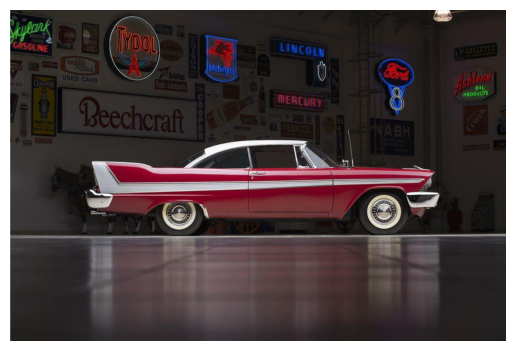

In [18]:
image_name = "178583_Side_Profile_Web.jpeg"

img = cv2.imread(os.path.join("/content/drive/MyDrive/COS_DL_2024/car-segmentation/images", image_name))[:, :, ::-1]

plt.imshow(img)
plt.axis('off')

(-0.5, 999.5, 667.5, -0.5)

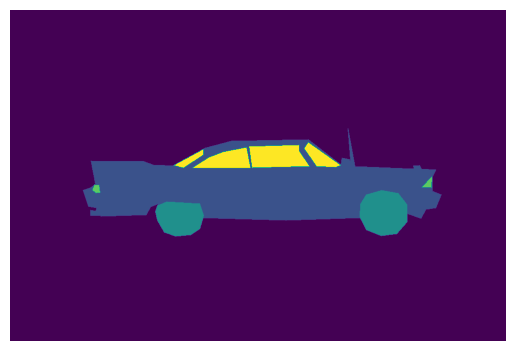

In [19]:
mask = cv2.imread(os.path.join("/content/drive/MyDrive/COS_DL_2024/car-segmentation/masks", image_name.replace('jpeg', 'png')), 0)

plt.imshow(mask)
plt.axis('off')

In [21]:
np.unique(mask)

array([0, 1, 2, 3, 4], dtype=uint8)

In [23]:
import albumentations
from albumentations.pytorch import ToTensorV2

train_transform = albumentations.Compose(
    [
        albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = albumentations.Compose(
    [
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [47]:
from os import listdir


import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split


class SegmentationDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, transforms, indices):
        self.transforms = None
        self.root_dir = images_dir
        self.masks_dir = masks_dir
        self.images = np.array(os.listdir(images_dir))[indices]
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx].replace('jpeg', 'png'))

        # work properly with mask
        img = cv2.resize(cv2.imread(img_path)[:, :, ::-1], (256, 256), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(cv2.imread(mask_path, 0), (256, 256), interpolation=cv2.INTER_NEAREST)


        transformed = self.transforms(image=img, mask=mask)
        return transformed["image"], transformed["mask"]

    def __len__(self):
        return len(self.images)

In [48]:
images_dir = "/content/drive/MyDrive/COS_DL_2024/car-segmentation/images"
masks_dir = "/content/drive/MyDrive/COS_DL_2024/car-segmentation/masks"


Для разбиения на train и test воспользуемся на этот раз утилитой из pytorch:

In [57]:
indices_mask = np.random.rand(211) > 0.2

In [60]:
train_indices = np.argwhere(indices_mask==True).reshape(-1)
val_indices = np.argwhere(indices_mask==False).reshape(-1)

In [63]:
train_dataset = SegmentationDataset(images_dir, masks_dir, train_transform, train_indices)
val_dataset = SegmentationDataset(images_dir, masks_dir, val_transform, val_indices)

In [64]:
print(f'Train_data: {len(train_dataset)} images \tVal_data: {len(val_dataset)} images', )

Train_data: 166 images 	Val_data: 45 images



### Описание модели

Модель UNet, используемая здесь, состоит из блоков. Каждый блок в свою очередь состоит из сверточных слоев + слоя batchNorm + активации ReLU, а также слоя maxPooling (в случае с энкодером) или conv_transpose (в случае с декодером). В каждом блоке кол-во фильтров соответственно 32, 64, 128, 256.

Bottleneck содержит 512 сверточных слоев. Блоки энкодера снабжены skip-connection, которые ведут непосредственно в блоки декодера.

Входное изображение трехканальное с необходимой предобработкой.

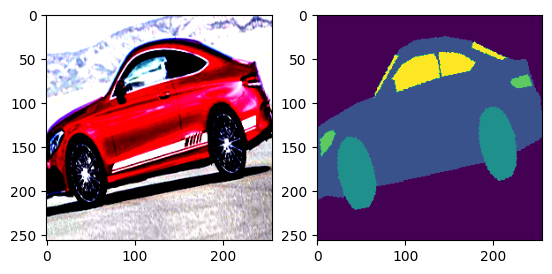

In [69]:
idx = 50
item = train_dataset[idx]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.moveaxis(item[0].numpy(),0,2))
ax[1].imshow(item[1])
plt.show()

Объявим даталоадеры:

In [70]:
loader_args = dict(batch_size=4, num_workers=2, pin_memory=True)

train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, **loader_args)

Воспользуемся моделью из библиотекм, но возьмем НЕ предобученную модель:

In [72]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [73]:
import segmentation_models_pytorch as smp

In [79]:
import timm

In [80]:
timm.list_models("*resnet*", pretrained=True)

['cspresnet50.ra_in1k',
 'eca_resnet33ts.ra2_in1k',
 'ecaresnet26t.ra2_in1k',
 'ecaresnet50d.miil_in1k',
 'ecaresnet50d_pruned.miil_in1k',
 'ecaresnet50t.a1_in1k',
 'ecaresnet50t.a2_in1k',
 'ecaresnet50t.a3_in1k',
 'ecaresnet50t.ra2_in1k',
 'ecaresnet101d.miil_in1k',
 'ecaresnet101d_pruned.miil_in1k',
 'ecaresnet269d.ra2_in1k',
 'ecaresnetlight.miil_in1k',
 'gcresnet33ts.ra2_in1k',
 'gcresnet50t.ra2_in1k',
 'inception_resnet_v2.tf_ens_adv_in1k',
 'inception_resnet_v2.tf_in1k',
 'lambda_resnet26rpt_256.c1_in1k',
 'lambda_resnet26t.c1_in1k',
 'lambda_resnet50ts.a1h_in1k',
 'legacy_seresnet18.in1k',
 'legacy_seresnet34.in1k',
 'legacy_seresnet50.in1k',
 'legacy_seresnet101.in1k',
 'legacy_seresnet152.in1k',
 'nf_resnet50.ra2_in1k',
 'resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_i

Библиотека smp поддерживает интеграцию с timm.

Чтобы в качестве энкодера (левая часть UNet) взять модель из timm, необходимо к названию модели из timm добавить префикс `tu`:

`tu-resnet34.a1_in1k`.

In [89]:
net = smp.Unet(encoder_name='tu-resnet34', classes=5) # фон, машина, колеса, фары, стекла

In [90]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, weight_decay=1e-8, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
criterion = nn.CrossEntropyLoss()

global_step = 0

### Sanity check

Не забываем прогнать рандомные данные через нейросеть (перед тем, как мы все отправим на ГПУ, где дебажить будет сложно)

In [91]:
rand_batch = torch.rand(1,3,256,256)

print(net(rand_batch).shape)

torch.Size([1, 5, 256, 256])


In [92]:
from torchsummary import summary

summary(net, (3,256,256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
          Identity-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
          Identity-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
       BasicBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

### Отправляем всё на ГПУ

In [94]:
#net.cuda()

## Метрика IoU (intersection over union)

<img src="https://miro.medium.com/v2/resize:fit:936/format:webp/1*r0o3vX-x979Q84_lbJWS_g.jpeg">

Метрика IoU показывает, как много "площади" объекта было корректно найдено нейросетью относительно объединенной площади предсказания и реального объекта.

Такая метрика более хорошо подходит, поскольку стандартная accuracy может быть очень большой из-за влияния фона.

### Запускаем обучение (training loop)

In [95]:
def compute_iou(mask, pred):
    pred = 1.0*(pred > 0.5)
    intersection = (mask * pred).sum()
    union = ((mask + pred)>0.).sum()
    return intersection/union

In [97]:
epochs = 10

torch.uint8

In [103]:
for epoch in range(epochs):
    net.train()
    epoch_loss = 0.
    epoch_iou = 0.
    print(f"Epoch {1+epoch}/{epochs}")

    for batch in train_loader:
        images = batch[0]
        true_masks = batch[1].long()

        #images = images.to('cuda', dtype=torch.float32)
        #true_masks = true_masks.to('cuda', dtype=torch.float32)

        masks_pred = net(images)

        loss = criterion(masks_pred, true_masks)

        iou = compute_iou(masks_pred[:,0,:,:].detach(), true_masks)
        epoch_iou += iou

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        global_step += 1
        epoch_loss += loss.item()
        if global_step%20==0:
            print(f"Avg loss: {epoch_loss/global_step}\t Avg_iou: {epoch_iou/global_step}")

    net.eval()
    val_epoch_loss = 0
    val_epoch_iou = 0.
    global_step = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image']
            true_masks = batch['mask']

            images = images.to('cuda', dtype=torch.float32)
            true_masks = true_masks.to('cuda', dtype=torch.float32)

            masks_pred = net(images)

            loss = criterion(masks_pred[:,0,:,:], true_masks)
            iou = compute_iou(masks_pred[:,0,:,:], true_masks)
            val_epoch_iou += iou

            global_step += 1
            val_epoch_loss += loss.item()
            if global_step%20==0:
                print(f"Avg loss: {epoch_loss/global_step}\t Avg_iou: {val_epoch_iou/global_step}")

Epoch 1/10
Avg loss: 1.109529075026512	 Avg_iou: 0.3775256872177124


KeyboardInterrupt: 

In [ ]:
img, mask = val_set[6]['image'], val_set[6]['mask']

In [ ]:
idx = 430
plt.imshow(np.moveaxis(img.numpy(),0,2))
plt.show()
plt.imshow(mask.numpy())
plt.show()

In [ ]:
img = img.to('cuda', dtype=torch.float32)

In [ ]:
pred = (net(img.reshape(1,3,256,256))> 0.5)*1.

In [ ]:
plt.imshow(pred[0][0].detach().cpu().numpy())

In [ ]:
plt.imshow(mask.numpy())
plt.show()